In [1]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=a5240d80ff744be08ad1ab6e2dae07509c902cfe7ca2e07922ac129ca6f61ce6
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


MOUNT THE DRIVE AND LOAD THE DATASET

In [2]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [4]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "lch_harmonies_dataset"

In [5]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 lch_database/
 lch_harmonies_dataset/
 LCH_UTILS.ipynb
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 winter_summer_dataset/


In [7]:
def lch_to_rgb(img,wasByte):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      lch = LCHabColor(pixel[0],pixel[1],pixel[2]/(256./360) if wasByte else pixel[2])
      rgb = convert_color(lch,sRGBColor)
      new_img[i,j]=np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
      ctr+=1
      if ctr%10000==0:
        print("converting image to rgb, did",ctr,"pixels")
  return new_img

TEST THE CONVERSION FUNCTIONS

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


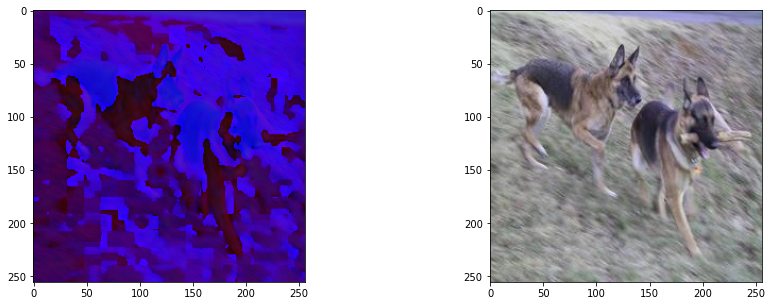

In [8]:
img_lch = Image.open("lch_harmonies_dataset/rectangle/78984436_ad96eaa802.jpg")

img_rgb = lch_to_rgb(np.array(img_lch),True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img_lch)

plt.subplot(1,2,2)
plt.imshow(img_rgb)

In [19]:
from torch.utils.data import Dataset

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path))
        horse_img = np.array(Image.open(horse_path))
        #!!!!! dans la base de données les teintes sont multipliées par 256./360. (pour rentrer sur un byte) (on garde ça comme ça.)
        zebra_img = (zebra_img/255.).astype(np.float16)
        horse_img = (horse_img/255.).astype(np.float16)

        print(zebra_img.shape)

        zebra_img = torch.Tensor(np.moveaxis(zebra_img,-1,0)).to(torch.device("cuda:0"))
        horse_img = torch.Tensor(np.moveaxis(horse_img,-1,0)).to(torch.device("cuda:0"))


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"mono"),os.path.join(root_data,"rectangle"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

(256, 256, 3)


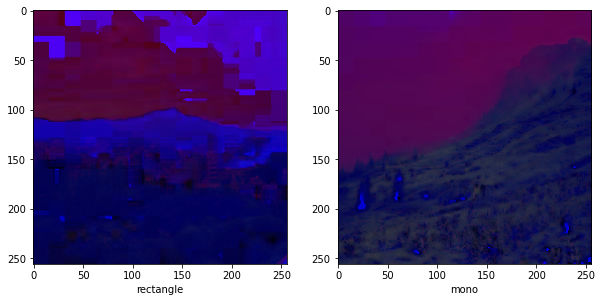

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


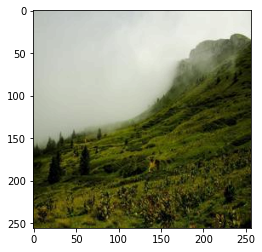

In [24]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1).reshape((256,256,3)))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1).reshape((256,256,3)))
plt.xlabel("mono")
plt.show()
plt.figure()
img_rgb = lch_to_rgb(np.moveaxis(np.array(summer.cpu()),0,-1).reshape((256,256,3))*255.,True)
plt.imshow(img_rgb)

#MODELS

In [25]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [26]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [27]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [28]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [29]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [37]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,2,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [38]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[ 0.4914,  0.5688,  0.5446,  ...,  0.3072,  0.3284, -0.0067],
         [ 0.3827,  0.0861,  0.4061,  ...,  0.2587,  0.2315,  0.1480],
         [-0.0325,  0.1185,  0.0051,  ...,  0.3923,  0.3431,  0.2078],
         ...,
         [ 0.1797,  0.2932,  0.3161,  ...,  0.0867,  0.1157,  0.2274],
         [ 0.6174,  0.4198,  0.1743,  ...,  0.0807,  0.2582,  0.3897],
         [ 0.0486, -0.0968, -0.0897,  ..., -0.0098,  0.1411,  0.1046]],

        [[-0.7134, -0.2536, -0.5269,  ..., -0.2057, -0.2164, -0.4331],
         [-0.3129, -0.3198, -0.4357,  ..., -0.5443, -0.2604, -0.2365],
         [-0.2472, -0.2752, -0.1776,  ..., -0.4761, -0.2804, -0.4907],
         ...,
         [-0.3338,  0.2045, -0.4001,  ..., -0.2603, -0.2337, -0.4156],
         [-0.5407, -0.3827, -0.2674,  ..., -0.1289, -0.2692, -0.3250],
         [-0.2917, -0.3614, -0.4565,  ..., -0.1113, -0.2339, -0.2643]]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [39]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [48]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        fake_summer = gen_S(winter)
        #generator only generates c and h, concatenate L channel to that before passing to either loss function
        fake_summer = torch.cat([winter[0,:,:].reshape((1,256,256)),fake_summer],axis=0)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
        loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

        #adversarial loss for winter discriminator
        fake_winter = gen_W(summer)
        fake_winter = torch.cat([summer[0,:,:].reshape((1,256,256)),fake_winter],axis=0)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
        loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

        #final D loss
        D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


      opt_d.zero_grad()
      D_loss.backward()
      opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        fake_summer = torch.cat([winter[0,:,:].reshape((1,256,256)),fake_summer],axis=0)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        fake_winter = torch.cat([summer[0,:,:].reshape((1,256,256)),fake_winter],axis=0)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        reco_summer = torch.cat([fake_winter[0,:,:].reshape((1,256,256)),reco_summer],axis=0)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_S(fake_summer)
        reco_winter = torch.cat([fake_summer[0,:,:].reshape((1,256,256)),reco_winter],axis=0)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [49]:
disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  6%|▋         | 1/16 [00:00<00:02,  7.32it/s]

(256, 256, 3)
(256, 256, 3)


 25%|██▌       | 4/16 [00:00<00:01,  9.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 38%|███▊      | 6/16 [00:00<00:01,  9.93it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 62%|██████▎   | 10/16 [00:01<00:00, 10.31it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


 75%|███████▌  | 12/16 [00:01<00:00, 10.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


100%|██████████| 16/16 [00:01<00:00, 10.43it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  2.927255630493164 Gloss adv :  0.5883527398109436 D loss :  0.486996054649353
(256, 256, 3)


18it [00:01, 10.56it/s]                        

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


22it [00:02, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


24it [00:02, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


28it [00:02, 10.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


30it [00:02,  9.79it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.5493210554122925 Gloss adv :  0.6447147130966187 D loss :  0.4383804500102997


32it [00:03,  9.03it/s]

(256, 256, 3)
(256, 256, 3)


34it [00:03,  8.84it/s]

(256, 256, 3)
(256, 256, 3)


36it [00:03,  8.78it/s]

(256, 256, 3)
(256, 256, 3)


38it [00:03,  8.81it/s]

(256, 256, 3)
(256, 256, 3)


40it [00:04,  8.77it/s]

(256, 256, 3)
(256, 256, 3)


42it [00:04,  8.60it/s]

(256, 256, 3)
(256, 256, 3)


44it [00:04,  8.81it/s]

(256, 256, 3)
(256, 256, 3)


46it [00:04,  8.56it/s]

(256, 256, 3)
Gloss adv :  2.106618881225586 Gloss adv :  0.6746529936790466 D loss :  0.37769708037376404
(256, 256, 3)


48it [00:05,  8.39it/s]

(256, 256, 3)
(256, 256, 3)


50it [00:05,  8.27it/s]

(256, 256, 3)
(256, 256, 3)


52it [00:05,  8.51it/s]

(256, 256, 3)
(256, 256, 3)


54it [00:05,  8.29it/s]

(256, 256, 3)
(256, 256, 3)


56it [00:06,  8.63it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


60it [00:06,  9.86it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


61it [00:06,  9.86it/s]

Gloss adv :  2.1406641006469727 Gloss adv :  0.6391399502754211 D loss :  0.40388885140419006
(256, 256, 3)
(256, 256, 3)


65it [00:06, 10.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


67it [00:07, 10.27it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


71it [00:07, 10.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


73it [00:07, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


77it [00:08, 10.27it/s]

(256, 256, 3)
Gloss adv :  1.6387323141098022 Gloss adv :  0.6843777298927307 D loss :  0.40870219469070435
(256, 256, 3)


79it [00:08, 10.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


81it [00:08, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


85it [00:08, 10.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


87it [00:08, 10.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


91it [00:09, 10.40it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.2940411567687988 Gloss adv :  0.583989143371582 D loss :  0.49813312292099
(256, 256, 3)


93it [00:09, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


97it [00:09, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


99it [00:10, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


103it [00:10, 10.61it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


105it [00:10, 10.60it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.6846091747283936 Gloss adv :  0.6741896867752075 D loss :  0.41173720359802246
(256, 256, 3)


109it [00:11, 10.56it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


111it [00:11, 10.52it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


115it [00:11, 10.55it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


117it [00:11, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


121it [00:12, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.3744723796844482 Gloss adv :  0.6578740477561951 D loss :  0.4417857527732849
(256, 256, 3)


123it [00:12, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


127it [00:12, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


129it [00:12, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


133it [00:13, 10.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


135it [00:13, 10.49it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.5128109455108643 Gloss adv :  0.7171615958213806 D loss :  0.3842773735523224
(256, 256, 3)


139it [00:13, 10.59it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


141it [00:14, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


145it [00:14, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


147it [00:14, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


151it [00:15, 10.38it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  0.945864200592041 Gloss adv :  0.9038417339324951 D loss :  0.30526456236839294
(256, 256, 3)


153it [00:15, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


157it [00:15, 10.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


159it [00:15, 10.50it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


163it [00:16, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


165it [00:16, 10.42it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.0578683614730835 Gloss adv :  0.8887622952461243 D loss :  0.33326196670532227
(256, 256, 3)


169it [00:16, 10.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


171it [00:17, 10.54it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


175it [00:17, 10.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


177it [00:17, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


181it [00:17, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.0919029712677002 Gloss adv :  0.9933781623840332 D loss :  0.24203410744667053
(256, 256, 3)


183it [00:18, 10.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


187it [00:18, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


189it [00:18, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


193it [00:19, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


195it [00:19, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
Gloss adv :  1.0734059810638428 Gloss adv :  1.0079582929611206 D loss :  0.2558084726333618
(256, 256, 3)


199it [00:19, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


201it [00:19, 10.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


205it [00:20, 10.48it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


207it [00:20, 10.43it/s]

(256, 256, 3)
(256, 256, 3)


209it [00:20, 10.29it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


211it [00:20, 10.21it/s]

Gloss adv :  1.3637664318084717 Gloss adv :  0.9914872646331787 D loss :  0.2633172273635864
(256, 256, 3)
(256, 256, 3)


215it [00:21, 10.32it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


217it [00:21, 10.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


221it [00:21, 10.45it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


223it [00:22, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


227it [00:22, 10.38it/s]

(256, 256, 3)
Gloss adv :  0.9456600546836853 Gloss adv :  1.023274540901184 D loss :  0.27616873383522034
(256, 256, 3)
(256, 256, 3)


229it [00:22, 10.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


233it [00:22, 10.51it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


235it [00:23, 10.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


239it [00:23, 10.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


241it [00:23, 10.24it/s]

(256, 256, 3)
Gloss adv :  0.8062779307365417 Gloss adv :  0.9796098470687866 D loss :  0.21082019805908203
(256, 256, 3)
(256, 256, 3)


245it [00:24, 10.41it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


247it [00:24, 10.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


251it [00:24, 10.38it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


253it [00:24, 10.39it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


257it [00:25, 10.23it/s]

(256, 256, 3)
Gloss adv :  0.9005951881408691 Gloss adv :  0.9849129915237427 D loss :  0.32332557439804077
(256, 256, 3)
(256, 256, 3)


259it [00:25, 10.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


263it [00:25, 10.36it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


265it [00:26, 10.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


269it [00:26, 10.42it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


271it [00:26, 10.21it/s]

(256, 256, 3)
Gloss adv :  0.8284205794334412 Gloss adv :  0.9953973293304443 D loss :  0.2745332717895508
(256, 256, 3)
(256, 256, 3)


275it [00:27, 10.40it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


277it [00:27, 10.43it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


281it [00:27, 10.47it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


283it [00:27, 10.35it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


287it [00:28, 10.41it/s]

(256, 256, 3)
Gloss adv :  0.88358074426651 Gloss adv :  0.981413722038269 D loss :  0.19171205163002014
(256, 256, 3)
(256, 256, 3)


289it [00:28, 10.37it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


293it [00:28, 10.46it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


295it [00:28, 10.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


299it [00:29, 10.44it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


301it [00:29, 10.41it/s]

(256, 256, 3)
Gloss adv :  1.1141923666000366 Gloss adv :  0.8941650390625 D loss :  0.3056955933570862
(256, 256, 3)
(256, 256, 3)


305it [00:29, 10.49it/s]

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


307it [00:30, 10.20it/s]

(256, 256, 3)


KeyboardInterrupt: ignored

(256, 256, 3)
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


TypeError: ignored

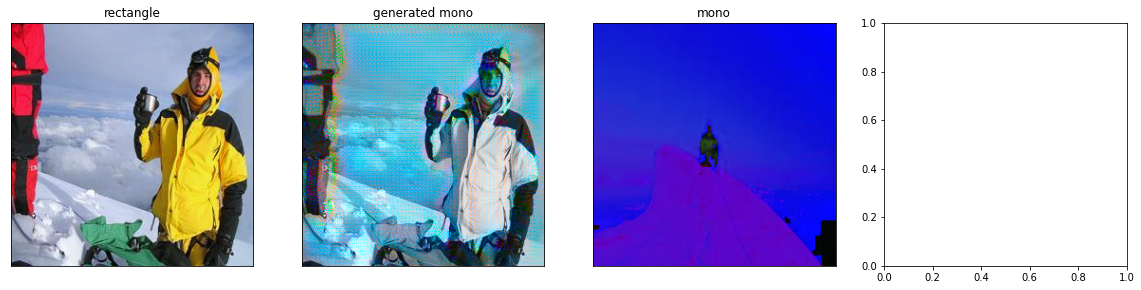

In [57]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
rgb_img = lch_to_rgb(np.moveaxis(np.array(winter.cpu()),0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,2)
genImg = gen_S(winter)
genImg = np.array(torch.cat([winter[0,:,:].reshape((1,256,256)),genImg],axis=0).cpu().detach())
rgb_img = lch_to_rgb(np.moveaxis(genImg,0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("generated mono")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("mono")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)